In [10]:
# imports

import itertools
import os
if os.getcwd().split("/")[-1] == "notebooks":
    os.chdir(os.pardir)
import time

import jax
import jax.numpy as jnp
import jax.nn as nn
from jax import vmap, jit, grad
from jax.experimental import optimizers
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.interpolate import interp1d
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

from src.field import poynting
from src.utils.integrate import elementwise_dblquad
from src.utils.viz import fig_config, save_fig
from src.utils.dataloader import load_antenna_el_properties

In [11]:
# jax.config.update('jax_enable_x64', True)

In [12]:
print(f'platform: {jax.lib.xla_bridge.get_backend().platform}')

platform: cpu


In [13]:
sns.set(style='ticks', palette='colorblind')

In [14]:
%config InlineBackend.figure_format = 'retina'

In [15]:
PROJECT_NAME = 'IRPA2022_paper'

In [16]:
# load pre-computed source data

f = 26e9  # operating frequency of the antenna
antenna_data = load_antenna_el_properties(f)
Is = antenna_data.ireal.to_numpy() + antenna_data.iimag.to_numpy() * 1j
Is = np.asarray(Is)
xs = antenna_data.x.to_numpy()

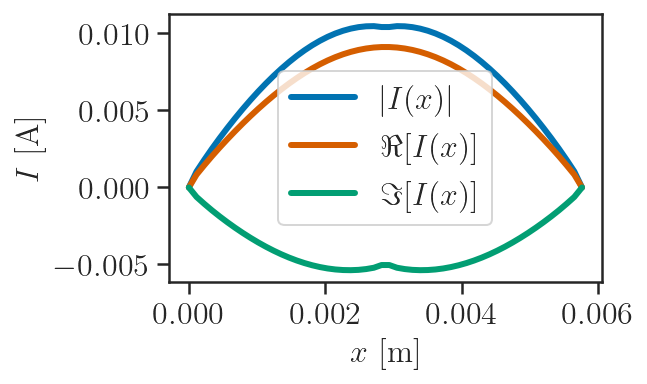

In [18]:
# visualize spatial current distribution

fig_config(latex=True)
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(xs, np.abs(Is), 'b-', label='$|I(x)|$')
ax.plot(xs, np.real(Is), 'r-', label='$\Re{[I(x)]}$')
ax.plot(xs, np.imag(Is), 'g-', label='$\Im{[I(x)]}$')
ax.set(xlabel='$x$ [m]', ylabel='$I$ [A]')
ax.legend()
fig.tight_layout();

fname = os.path.join('figures', PROJECT_NAME, 'I_dist')
save_fig(fig, fname=fname)

In [19]:
def forward_diff(fn, h=1e-6):
    """Forward difference y = np.abs(I_an) * 1000  # in mAapproximation."""
    def dfn_dx(x):
        return (fn(x + h) - fn(x)) / h
    return dfn_dx
    
    
def backward_diff(fn, h=1e-6):
    """Backward difference approximation."""
    def dfn_dx(x):
        return (fn(x) - fn(x - h)) / h
    return dfn_dx

    
def central_diff(fn, h=1e-6):
    """Central difference approximation."""
    def dfn_dx(x):
        return (fn(x + h) - fn(x - h)) / (2 * h)
    return dfn_dx


def complex_step_diff(fn, h=1e-6):
    """Complex-step difference approximation.
    
    Note: Incompatible with SciPy interpolation module.
    """
    def dfn_dx(x):
        return np.imag(fn(x + 1j * h)) / h
    return dfn_dx

In [20]:
# quadratic interpolation of current distribution function

Is_fn = interp1d(xs, np.abs(Is), kind='quadratic')

xs_interp = np.linspace(xs.min(), xs.max(), 1001)
Is_interp = Is_fn(xs_interp)

In [21]:
# mean relative error

error = np.mean(np.abs(np.abs(Is)[1:-1] - Is_fn(xs)[1:-1]) / np.abs(Is)[1:-1])
print(f'relative error = {error * 100:.2e} %')

relative error = 5.64e-15 %


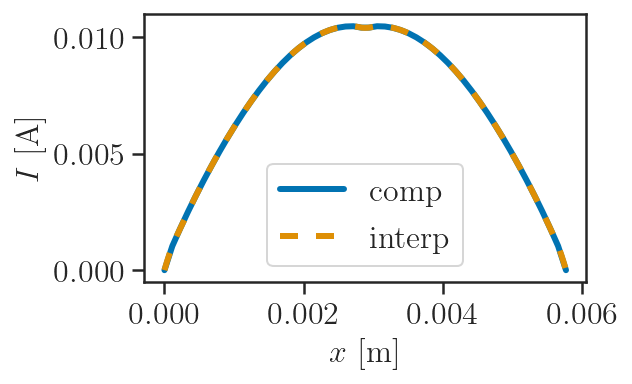

In [23]:
# visualize spatial current distribution as calculated and interpolated

fig_config(latex=True)
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(xs, np.abs(Is), label='comp')
ax.plot(xs_interp, Is_interp, '--', label='interp')
ax.set(xlabel='$x$ [m]', ylabel='$I$ [A]')
ax.legend()
fig.tight_layout();

fname = os.path.join('figures', PROJECT_NAME, 'I_interp')
save_fig(fig, fname=fname)

In [24]:
# finite difference on computed and interpolated data

dIsdxs = np.r_[(forward_diff(Is_fn)(xs[0]),
                central_diff(Is_fn)(xs[1:-1]),
                backward_diff(Is_fn)(xs[-1]))]
dIsdxs_interp = np.r_[(forward_diff(Is_fn)(xs_interp[0]),
                       central_diff(Is_fn)(xs_interp[1:-1]),
                       backward_diff(Is_fn)(xs_interp[-1]))]

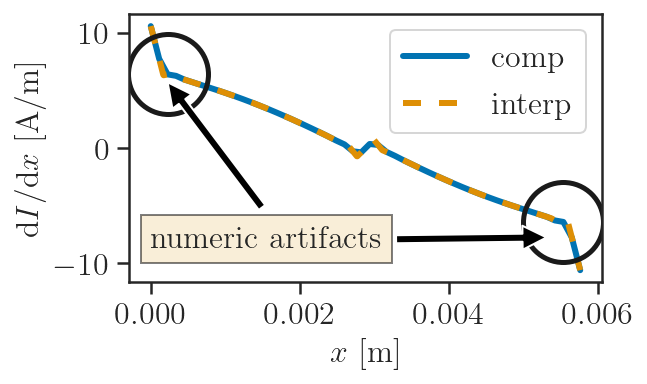

In [26]:
# visualize current gradient distribution as calculated and interpolated

fig_config(latex=True)
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(xs, dIsdxs, label='comp')
ax.plot(xs_interp, dIsdxs_interp, '--', label='interp')
ax.plot([xs[2], xs[-3]], [dIsdxs[2], dIsdxs[-3]], 'ko', fillstyle='none',
        markersize=40, markeredgewidth=2.5)
ax.annotate('', xy=(xs[2], dIsdxs[5]),
            xytext=(xs[11] + 0.00025, -dIsdxs[2] + 1.25),
            arrowprops={'facecolor': 'black'})
ax.annotate('', xy=(xs[-5], dIsdxs[-2]),
            xytext=(xs[11] + 0.00205, -dIsdxs[2] - 1.5), 
            arrowprops={'facecolor': 'black'})
ax.text(xs[0], -dIsdxs[0] + 2, s='numeric artifacts',
        bbox={'facecolor': 'wheat',
              'edgecolor': 'black',
              'alpha': 0.5,
              'pad': 5})
ax.set(xlabel='$x$ [m]', ylabel=r'$\mathrm{d}I$/$\mathrm{d}x$ [A/m]')
ax.legend()
fig.tight_layout();

fname = os.path.join('figures', PROJECT_NAME, 'I_grad_fd')
save_fig(fig, fname=fname)

In [27]:
def normalize(ref_data, data):
    """Min-max scaling the features to the [0, 1] range."""
    norm_data = (data - min(ref_data)) / (max(ref_data) - min(ref_data))
    return norm_data


def inv_normalize(norm_data, ref_data):
    """Recovering the initial feature values after min-max scaling."""
    data = min(ref_data) + norm_data * (max(ref_data) - min(ref_data))
    return data


def standardize(ref_data, data):
    """Features are set to have zero-mean and unit-variance."""
    st_data = (data - jnp.mean(ref_data)) / jnp.std(ref_data)
    return st_data


def inv_standardize(st_data, ref_data):
    """Recovering initial feature values after standardization."""
    data = st_data * jnp.std(ref_data) + jnp.mean(ref_data)
    return data

In [28]:
rng = jax.random.PRNGKey(0)

def init_network_params(sizes, key):
    """Initialize network parameters."""
    keys = jax.random.split(key, len(sizes))
    def random_layer_params(m, n, key, scale=1e-2):
        w_key, b_key = jax.random.split(key)
        return (scale * jax.random.normal(w_key, (n, m)),
                scale * jax.random.normal(b_key, (n, )))
    return [random_layer_params(m, n, key)
            for m, n, key in zip(sizes[:-1], sizes[1:], keys)]


def forward(params, X, scaler):
    """Forward pass."""
    output = X
    for w, b in params[:-1]:
        output = nn.tanh(w @ output + b)
    w, b = params[-1]
    output = w @ output + b
    return output * scaler


# vectorized mapping of network input, `X`, on `forward` function
batch_forward = vmap(forward, in_axes=(None, 0, None))


@jit
def loss_fn(params, batch, scaler):
    """Summed square error loss function."""
    X, y = batch
    y_pred = batch_forward(params, X, scaler)
    return jnp.sum(jnp.square(y_pred - y))


# derivative of the loss function
grad_fn = jit(grad(loss_fn))


@jit
def update(step, optim_state, batch, scaler):
    """Return current optimal state of the network."""
    params = optim_params(optim_state)
    grads = grad_fn(params, batch, scaler)
    optim_state = optim_update(step, grads, optim_state)
    return optim_state

In [29]:
xs_norm = normalize(xs_interp, xs_interp)
xs_data = jnp.array(xs_norm).reshape(-1, 1)
# the following scaling is a bit weird but is needed in order to keep
# gradients of the nn output wrt input (not parameters, but actual input) in
# the same scale with the ones that are computed via FDM
Is_norm = normalize(xs_interp, Is_interp)
Is_data = jnp.array(Is_norm).reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(xs_data, Is_data, test_size=0.25)

In [39]:
# set network hyperparameter and train

# to set the output of the nn in scale with the target data, we define scaler
scaler = np.abs(y_train).max()
step_size = 1e-3
n_epochs = 10_000
printout = int(n_epochs / 100.)
epochs = np.arange(0, n_epochs+1, step=printout)
batch_size = 128
momentum_mass = 0.9  # for momentum and adagrad
sizes = [1, 128, 256, 128, 1]

num_train = X_train.shape[0]
num_complete_batches, leftover = divmod(num_train, batch_size)
num_batches = num_complete_batches + bool(leftover)


def data_stream(num_train, num_batches):
    """Training data random generator."""
    rng = npr.RandomState(0)
    while True:
        perm = rng.permutation(num_train)
        for i in range(num_batches):
            batch_idx = perm[i * batch_size:(i + 1) * batch_size]
            yield X_train[batch_idx], y_train[batch_idx]
            

batches = data_stream(num_train, num_batches)

optim_init, optim_update, optim_params = optimizers.adam(step_size)
init_params = init_network_params(sizes, rng)
optim_state = optim_init(init_params)
itercount = itertools.count()
 
loss_train, loss_test = [], []
params_list = []
start_time = time.time()
pbar = tqdm(range(n_epochs))
for epoch in pbar:
    start_epoch_time = time.time()
    for _ in range(num_batches):
        optim_state = update(next(itercount), optim_state, next(batches), scaler)
    epoch_duration = time.time() - start_epoch_time
    
    params = optim_params(optim_state)
    if (epoch == 0) or (epoch % printout == (printout - 1)):
        params_list.append(params)
        curr_loss_train_val = loss_fn(params, (X_train, y_train), scaler)
        curr_loss_test_val = loss_fn(params, (X_test, y_test), scaler)
        loss_train.append(curr_loss_train_val)
        loss_test.append(curr_loss_test_val)
        pbar.set_description(f'Loss (test): {curr_loss_test_val:.4e}')
training_duration = time.time() - start_time
print(f'Training time: {training_duration:.2f} s')

  0%|          | 0/10000 [00:00<?, ?it/s]

Training time: 194.56 s


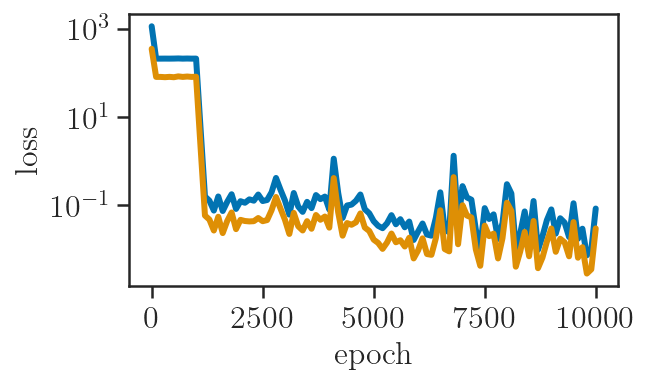

In [40]:
# visualize training loss dynamics

fig_config(latex=True)
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(epochs, loss_train, label='train set')
ax.plot(epochs, loss_test, label='test set')
ax.set(xlabel='epoch', ylabel='loss', yscale='log')
fig.tight_layout();

fname = os.path.join('figures', PROJECT_NAME, 'loss')
save_fig(fig, fname=fname)

In [41]:
# choose params with the best performance on test set

best_params_idx = loss_test.index(min(loss_test))
params = params_list[best_params_idx]

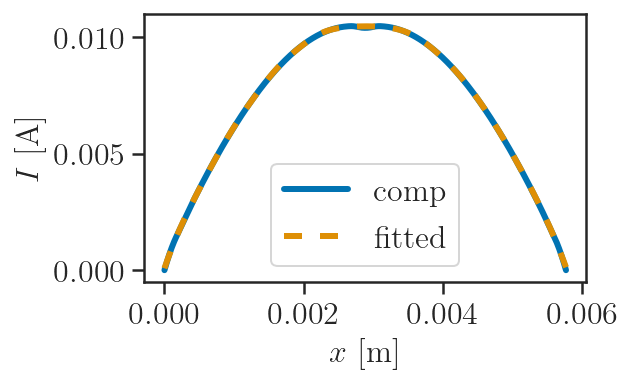

In [42]:
# visualize spatial current distribution as calculated and fitted

Is_fit = batch_forward(params, xs_data.reshape(-1, 1), scaler)
Is_fit_inv_norm = inv_normalize(Is_fit, xs_interp)

fig_config(latex=True)
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(xs_interp, Is_interp, label='comp')
ax.plot(xs_interp, Is_fit_inv_norm, '--', label='fitted')
ax.set(xlabel='$x$ [m]', ylabel='$I$ [A]')
ax.legend()
fig.tight_layout();

fname = os.path.join('figures', PROJECT_NAME, 'I_fit')
save_fig(fig, fname=fname)

In [43]:
def Is_nn(xs):
    """Current value at specific location, `xs`.
    
    Note: This is single-value wrapper for the forward pass function.
    """
    return forward(params, xs, scaler)[0]


# derivative of the current approximation function
grad_Is_nn = jit(vmap(grad(Is_nn)))

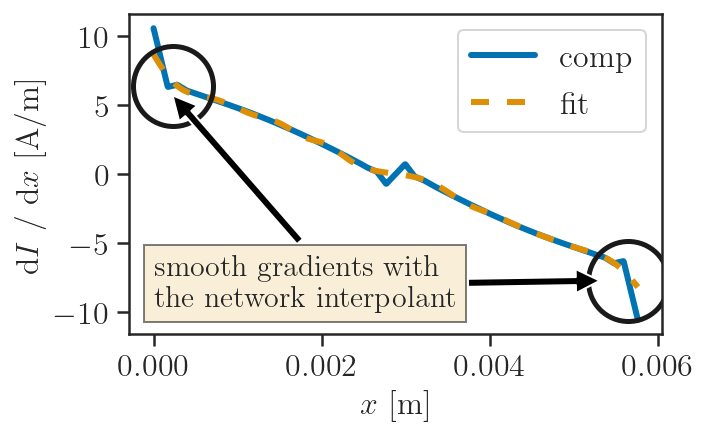

In [44]:
# visualize current gradient distribution as calculated and fitted

fig_config(latex=True)
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(xs_interp, dIsdxs_interp, label='comp')
ax.plot(xs_interp, grad_Is_nn(xs_data), '--', label='fit')
ax.plot([xs[2], xs[-2]], [dIsdxs[2], dIsdxs[-2]], 'ko', fillstyle='none',
        markersize=40, markeredgewidth=2.5)
ax.annotate('', xy=(xs[2], dIsdxs[5]),
            xytext=(xs[11] + 0.0005, -dIsdxs[2] + 1.5), 
            arrowprops={'facecolor': 'black'})
ax.annotate('', xy=(xs[-5], dIsdxs[-2]),
            xytext=(xs[11] + 0.0025, -dIsdxs[2] - 1.5), 
            arrowprops={'facecolor': 'black'})
ax.text(xs[0], -dIsdxs[0] + 1, fontsize=15,
        s='smooth gradients with\nthe network interpolant',        
        bbox={'facecolor': 'wheat',
              'edgecolor': 'black',
              'alpha': 0.5,
              'pad': 5})
ax.set(xlabel='$x$ [m]', ylabel=r'$\mathrm{d}I$ / $\mathrm{d}x$ [A/m]')
ax.legend();

fname = os.path.join('figures', PROJECT_NAME, 'I_grad_ad')
save_fig(fig, fname=fname)

In [38]:
# antenna coordinates
ys = jnp.zeros_like(xs)
zs = jnp.zeros_like(xs)

# effective radiated skin area
target_area = (0.02, 0.02)  # 2 x 2 cm2
A = target_area[0] * target_area[1]
h = -5 / 1000  # distance from the antenna
N = [33, 33, 0]
xt = np.linspace(-target_area[0] / 2, target_area[0] / 2, N[0]) + xs[-1] / 2
yt = np.linspace(-target_area[1] / 2, target_area[1] / 2, N[1])
zt = 0.

In [ ]:
# fdm approach

S = np.empty((xt.size, yt.size), dtype=np.complex64)
for xi, _xt in enumerate(xt):
    for yi, _yt in enumerate(yt):
        _Sx, _Sy, _Sz = poynting(_xt, _yt, zt, xs, ys, zs, f, Is, Is_x=dIsdxs)
        S[xi, yi] = np.sqrt(_Sx ** 2 + _Sy ** 2 + _Sz ** 2)
Sab_fdm = 1 / (2 * A) * elementwise_dblquad(S.real, xt, yt)
Sab_fdm

In [ ]:
# autodiff approach

dIs_nndxs = grad_Is_nn(jnp.array(normalize(xs, xs)).reshape(-1, 1)).flatten()
S = np.empty((xt.size, yt.size), dtype=np.complex64)
for xi, _xt in enumerate(xt):
    for yi, _yt in enumerate(yt):
        _Sx, _Sy, _Sz = poynting(_xt, _yt, zt, xs, ys, zs, f, Is, Is_x=dIs_nndxs)
        S[xi, yi] = np.sqrt(_Sx ** 2 + _Sy ** 2 + _Sz ** 2)
Sab_ad = 1 / (2 * A) * elementwise_dblquad(S.real, xt, yt)
Sab_ad